In [64]:
# import packages:
import numpy as np                   # Numeric Python
import matplotlib.pyplot as plt      # Plotting routines
import h5py                          # general HDF5 reading/writing library
import rioxarray as rx               # Package to read raster data from hdf5 files
from pyproj import Transformer, CRS  # libraries to allow coordinate transforms
import glob                          # Package to locate files on disk
import os                            # File-level utilities
import re                            # regular expressions for string interpretation
import icepyx as ipx                 # Package to interact with ICESat-2 online resources
from sliderule import icesat2        # Package for online ICESat-2 processing

In [65]:
%matplotlib inline

In [66]:
# logins, etc.

#HOST = 'https://urs.earthdata.nasa.gov'
#ipx.core.Earthdata.Earthdata('ben_smith','whatever@whatever.io', HOST).login()

url="icesat2sliderule.org"
icesat2.init(url, verbose=False)

In [67]:
crs=CRS.from_epsg(3031)
to_xy_crs=Transformer.from_crs(crs.geodetic_crs, crs)
to_geo_crs=Transformer.from_crs(crs, crs.geodetic_crs)
North_box = dict(x = [-450, -375, -375, -450, -450], y = [-100, -115, -100, -90, -100], name='North')
South_box = dict(x = [ -450, -375, -375, -450, -450,], y = [-100, -115, -140, -115, -100], name='South')
corners_lat_South, corners_lon_South=to_geo_crs.transform(np.array(South_box['y'])*1000, np.array(South_box['x'])*1000)
corners_lat_North, corners_lon_North=to_geo_crs.transform(np.array(North_box['y'])*1000, np.array(North_box['x'])*1000)
print(corners_lat_South, corners_lon_South)

[-85.7591818  -86.39112827 -86.31716614 -85.72715106 -85.7591818 ] [-167.47119229 -162.95096903 -159.52772048 -165.66456458 -167.47119229]


In [68]:
# Annika's bounding box:
# x,y
#-340,-80
#-480,-170

#XR= np.array([-480, -340])*1.e3
#YR= np.array([-170, -80])*1.e3

# shrink down to a tiny box in the center:
#XR=np.mean(XR)+np.array([-5.e3, 5.e3])
#YR=np.mean(YR)+np.array([-5.e3, 5.e3])


# Prepare coordinate transformations between lat/lon and polar stereographic
#crs=CRS.from_epsg(3031)
#to_xy_crs=Transformer.from_crs(crs.geodetic_crs, crs)
#to_geo_crs=Transformer.from_crs(crs, crs.geodetic_crs)

#corners_lat_South, corners_lon_South=to_geo_crs.transform(np.array(XR)[[0, 1, 1, 0, 0]], np.array(YR)[[0, 0, 1, 1, 0]])
latlims=[np.min(corners_lat_South), np.max(corners_lat_South)]
lonlims=[np.min(corners_lon_South), np.max(corners_lon_South)]

In [69]:
# run a slideRule ATL06 query.  Just ask for cycle 8 (Antarctic winter, 2020)
# to avoid getting swamped right away

# See parameters here:
# http://icesat2sliderule.org/rtd/user_guide/ICESat-2.html
params= { 'poly':[{'lon':this_lon, 'lat':this_lat} for this_lon, this_lat in zip(corners_lon_South, corners_lat_South)],
        'srt':3,
        'cnf':1,
        'len':10,
         'res':10,
         'ats':5,
         'cnt':10,
         'cycle':8,
         'maxi': 10,
        'pass_invalid':False}

D_IS_SR=icesat2.atl06p(params, 
                     asset="nsidc-s3")

In [70]:
#D_IS_SR[0:100]

In [71]:
#D_IS_SR.n_fit_photons .count()

In [72]:
# even spots = weak beams
D_IS_SR_even_spots = D_IS_SR[(D_IS_SR.spot % 2==0)]

In [73]:
# odd spots = strong beams
D_IS_SR_odd_spots = D_IS_SR[(D_IS_SR.spot % 2!=0)]

In [74]:
#Preview
#D_IS_SR_even_spots.head(3)
#D_IS_SR_odd_spots.head(3)

In [75]:
#print("All:",D_IS_SR['n_fit_photons'].count())
#print("Even spots:",D_IS_SR_even_spots['n_fit_photons'].count())
#print("Odd spots:",D_IS_SR_odd_spots['n_fit_photons'].count())

In [76]:
lon=np.array([gi.x for gi in D_IS_SR.geometry])
lat=np.array([gi.y for gi in D_IS_SR.geometry])
xy=to_xy_crs.transform(lat, lon)

In [77]:
#lon_e=np.array([gi.x for gi in D_IS_SR_even_spots.geometry])
#lat_e=np.array([gi.y for gi in D_IS_SR_even_spots.geometry])
#xy_e=to_xy_crs.transform(lat_e, lon_e)

In [78]:
lon_o=np.array([gi.x for gi in D_IS_SR_odd_spots.geometry])
lat_o=np.array([gi.y for gi in D_IS_SR_odd_spots.geometry])
xy_o=to_xy_crs.transform(lat_o, lon_o)

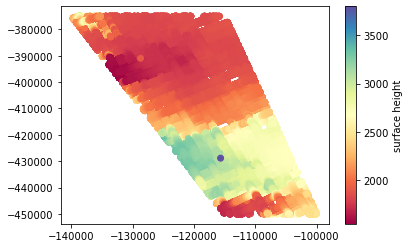

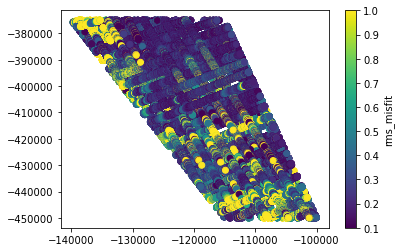

In [79]:
# All beams
plt.figure(); plt.scatter(xy[0], xy[1], c=D_IS_SR['h_mean'], cmap='Spectral'); plt.colorbar(label='surface height')
plt.figure(); plt.scatter(xy[0], xy[1], c=D_IS_SR['rms_misfit'], vmin=0.1, vmax=1); plt.colorbar(label='rms_misfit')

In [80]:
# Weak beam (even spot number)
#plt.figure(); plt.scatter(xy_e[0], xy_e[1], c=D_IS_SR_even_spots['h_mean'], cmap='Spectral'); plt.colorbar(label='surface height')
#plt.figure(); plt.scatter(xy_e[0], xy_e[1], c=D_IS_SR_even_spots['rms_misfit'], vmin=0.1, vmax=1); plt.colorbar(label='rms_misfit')

#plt.figure(); plt.hist(D_IS_SR_even_spots['rms_misfit'], np.arange(0, 2, 0.01));

#sigma_extra_e=np.sqrt(np.maximum(0, D_IS_SR_even_spots['rms_misfit']**2-(0.68e-9*1.5e8)**2))
#plt.figure(); plt.hist(sigma_extra_e, np.arange(0, .5, 0.01));

#plt.figure(); plt.scatter(xy_e[0], xy_e[1], c=sigma_extra_e, vmin=0, vmax=0.5); plt.colorbar(label='roughness?')

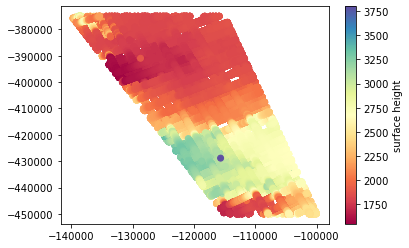

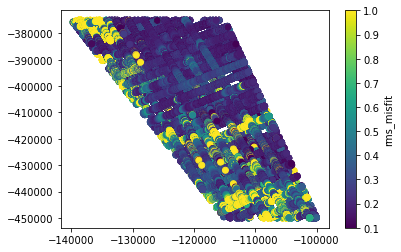

In [81]:
# Strong beams (odd spot number)
plt.figure(); plt.scatter(xy_o[0], xy_o[1], c=D_IS_SR_odd_spots['h_mean'], cmap='Spectral'); plt.colorbar(label='surface height')
plt.figure(); plt.scatter(xy_o[0], xy_o[1], c=D_IS_SR_odd_spots['rms_misfit'], vmin=0.1, vmax=1); plt.colorbar(label='rms_misfit')

In [82]:
#f, axa = plt.subplots(1,2,figsize=(10,3))
#plt.scatter(xy[0], xy[1], c=D_IS_SR['h_mean'], cmap='Spectral'); 
#axa[0].colorbar(label='surface height', ax=axa[0])
#axa[0].set_title('ALL')
#f.colorbar(m, ax=axa[0])
#f.colorbar(m, ax=axa[1]);

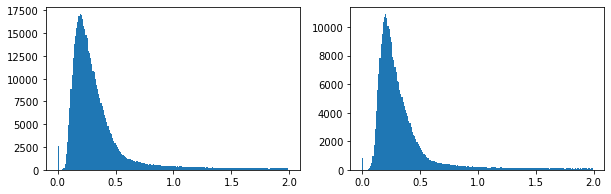

In [83]:
f, axa = plt.subplots(1,2,figsize=(10,3))
axa[0].hist(D_IS_SR['rms_misfit'], np.arange(0, 2, 0.01))
axa[1].hist(D_IS_SR_odd_spots['rms_misfit'], np.arange(0, 2, 0.01));

In [84]:
#plt.figure(); plt.hist(D_IS_SR['rms_misfit'], np.arange(0, 2, 0.01));

In [85]:
#plt.figure(); plt.hist(D_IS_SR_odd_spots['rms_misfit'], np.arange(0, 2, 0.01));

In [86]:
sigma_extra=np.sqrt(np.maximum(0, D_IS_SR['rms_misfit']**2-(0.68e-9*1.5e8)**2))
D_IS_SR_odd_spots['sigma_extra_o']=np.sqrt(np.maximum(0, D_IS_SR_odd_spots['rms_misfit']**2-(0.68e-9*1.5e8)**2))

/srv/conda/envs/notebook/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


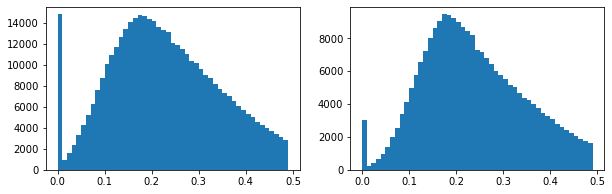

In [87]:
f, axa = plt.subplots(1,2,figsize=(10,3))
axa[0].hist(sigma_extra, np.arange(0, .5, 0.01));
axa[1].hist(D_IS_SR_odd_spots['sigma_extra_o'], np.arange(0, .5, 0.01));

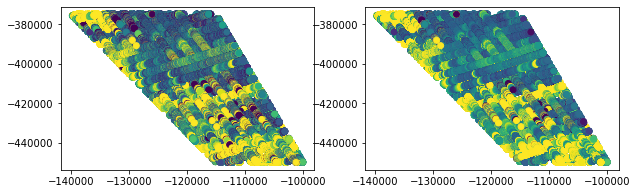

In [88]:
f, axa = plt.subplots(1,2,figsize=(10,3))
axa[0].scatter(xy[0], xy[1], c=sigma_extra, vmin=0, vmax=0.5); 
axa[1].scatter(xy_o[0], xy_o[1], c=D_IS_SR_odd_spots['sigma_extra_o'], vmin=0, vmax=0.5);

In [89]:
#plt.figure();plt.scatter(xy_o[0], xy_o[1], c=D_IS_SR_odd_spots['sigma_extra_o'], vmin=0, vmax=0.5); plt.colorbar(label='roughness?')

In [90]:
#plt.figure(); plt.hist(sigma_extra_o, np.arange(0, .5, 0.01));
# Aim to remove the peak near 0.0--->look at sigma_extra_o

In [91]:
D_IS_SR_odd_spots['sigma_extra_o'] = np.sqrt(np.maximum(0, D_IS_SR_odd_spots['rms_misfit']**2-(0.68e-9*1.5e8)**2))

In [92]:
#D_IS_SR_odd_spots.n_fit_photons.count()

In [93]:
#D_IS_SR_odd_spots[D_IS_SR_odd_spots['sigma_extra_o']==0].n_fit_photons.count()

In [94]:
# filter the data based on sigma_extra_o
D_IS_SR_odd_spots_corrected = D_IS_SR_odd_spots[D_IS_SR_odd_spots['sigma_extra_o']!=0]

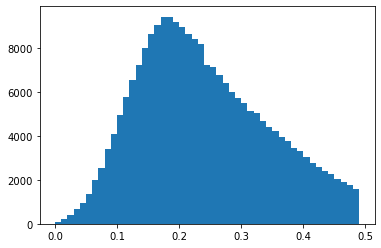

In [95]:
plt.figure(); plt.hist(D_IS_SR_odd_spots_corrected['sigma_extra_o'], np.arange(0, .5, 0.01));

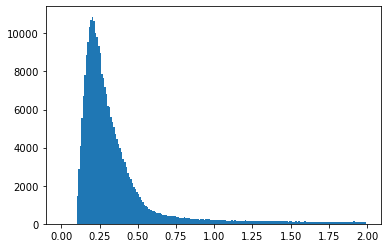

In [96]:
# RMS (not sigma_extra) fit for corrected odd spots data and sigma_extra==0
plt.figure(); plt.hist(D_IS_SR_odd_spots_corrected['rms_misfit'], np.arange(0, 2, 0.01));

In [97]:
# sigma_extra!=0
#D_IS_SR_odd_spots_corrected.head(3)

In [98]:
# Dataframe with spot = odd numbers
D_IS_SR_odd_spots[D_IS_SR_odd_spots['n_fit_photons']<=100].n_fit_photons.count()

180229

In [99]:
# Checking the peak around 0 for sigma_extra in the dataframe
D_IS_SR_odd_spots[D_IS_SR_odd_spots['sigma_extra_o']==0].n_fit_photons.count()

2963

In [100]:
# Dataframe with sigma_extra=0 values removed 
D_IS_SR_odd_spots_corrected[D_IS_SR_odd_spots_corrected['n_fit_photons']<100].n_fit_photons.count()

174432

In [101]:
# Dataframe with sigma_extra=0 values removed 
D_IS_SR_odd_spots_corrected[D_IS_SR_odd_spots_corrected['n_fit_photons']<=100].n_fit_photons.count()
# does it show that all of 186 points are less than 100 but we have more points that are less than 100? 
#not from the graphs

177332

In [102]:
# filter the data based on no of photons and spot 
D_IS_SR_odd_spots_p100 = D_IS_SR_odd_spots[D_IS_SR_odd_spots['n_fit_photons']>100]

In [103]:
D_IS_SR_odd_spots_p100['n_fit_photons'].count()

99627

In [104]:
D_IS_SR_odd_spots_p100[D_IS_SR_odd_spots_p100['sigma_extra_o']==0].n_fit_photons.count()

66

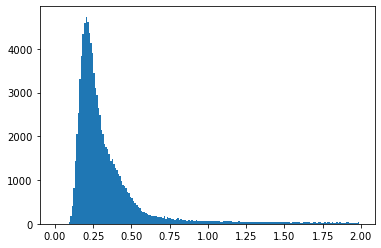

In [105]:
# RMS fit for odd spots dataframe corrected (i.e. spot =odd, no. of photons>100)
plt.figure(); plt.hist(D_IS_SR_odd_spots_p100['rms_misfit'], np.arange(0, 2, 0.01));

In [106]:
D_IS_SR_odd_spots_p100['rms_misfit'].max()

11.549861287184653

In [107]:
# filter the data based on no of photons, spot and sigma_extra!=0
D_IS_SR_odd_spots_p100_corrected = D_IS_SR_odd_spots_p100[D_IS_SR_odd_spots_p100['sigma_extra_o']!=0]

In [108]:
D_IS_SR_odd_spots_p100_corrected['n_fit_photons'].count()

99561

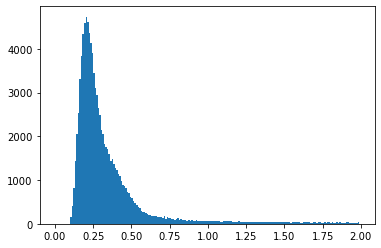

In [109]:
# RMS fit for odd spots dataframe corrected (i.e. spot =odd, no. of photons>100, sigma_extra=0)
plt.figure(); plt.hist(D_IS_SR_odd_spots_p100_corrected['rms_misfit'], np.arange(0, 2, 0.01));

In [110]:
D_IS_SR_odd_spots_p100_corrected['rms_misfit'].max()

11.549861287184653

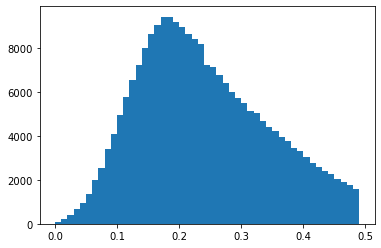

In [111]:
plt.figure(); plt.hist(D_IS_SR_odd_spots_corrected['sigma_extra_o'], np.arange(0, .5, 0.01));

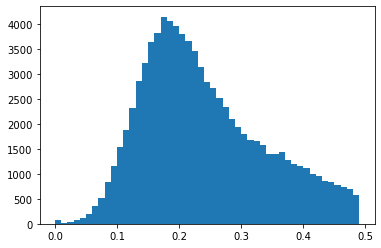

In [112]:
plt.figure(); plt.hist(D_IS_SR_odd_spots_p100['sigma_extra_o'], np.arange(0, .5, 0.01));

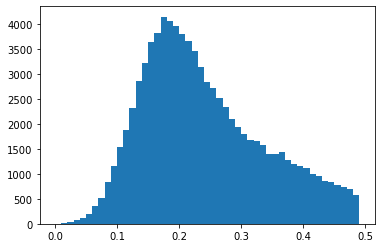

In [113]:
plt.figure(); plt.hist(D_IS_SR_odd_spots_p100_corrected['sigma_extra_o'], np.arange(0, .5, 0.01));

In [114]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [115]:
import seaborn as sns

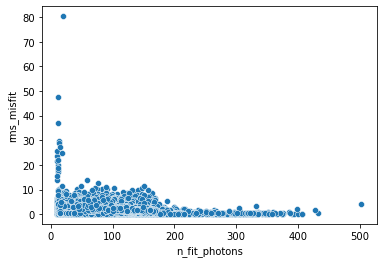

In [116]:
sns.scatterplot(x="n_fit_photons", y="rms_misfit", data=D_IS_SR_odd_spots_corrected);

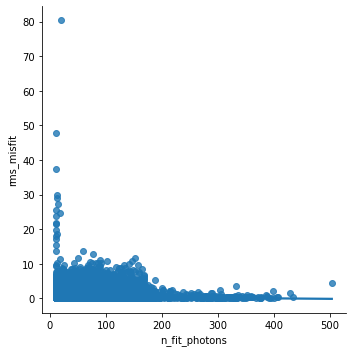

In [117]:
#Best fit line -- datafframe corrected (i.e. spot =odd, sigma_extra>0)
sns.lmplot(x="n_fit_photons", y="rms_misfit", data=D_IS_SR_odd_spots_corrected);

In [118]:
from scipy import stats
stats.pearsonr(D_IS_SR_odd_spots_corrected['n_fit_photons'], D_IS_SR_odd_spots_corrected['rms_misfit'])

(-0.08809219983607347, 0.0)

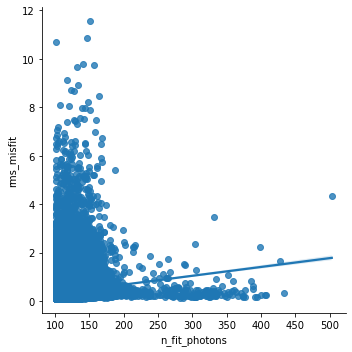

In [119]:
#Best fit line -- dataframe corrected (i.e. spot =odd, no. of photons>100)
sns.lmplot(x="n_fit_photons", y="rms_misfit", data=D_IS_SR_odd_spots_p100);
#plt.xlim([100,180]);

In [120]:
stats.pearsonr(D_IS_SR_odd_spots_p100['n_fit_photons'], D_IS_SR_odd_spots_p100['rms_misfit'])

(0.1304968991388851, 0.0)

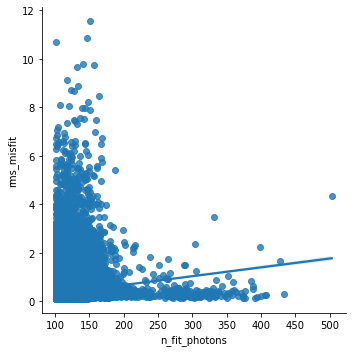

In [121]:
 #Best fit line -- datafframe corrected (i.e. spot =odd, sigma_extra>0)
sns.lmplot(x="n_fit_photons", y="rms_misfit", data=D_IS_SR_odd_spots_p100_corrected);

In [122]:
stats.pearsonr(D_IS_SR_odd_spots_p100_corrected['n_fit_photons'], D_IS_SR_odd_spots_p100_corrected['rms_misfit'])

(0.13035435998211525, 0.0)

In [131]:
#D_IS_SR_odd_spots_p100_corrected

In [126]:
# checking correlation
corr = D_IS_SR_odd_spots_p100_corrected.corr()
corr

,n_fit_photons,h_mean,dh_fit_dx,spot,dh_fit_dy,cycle,gt,distance,pflags,rms_misfit,h_sigma,segment_id,delta_time,rgt,w_surface_window_final,sigma_extra_o
n_fit_photons,1.000000,0.239007,-0.022878,0.029436,NaN,NaN,-0.029436,0.005751,0.019139,0.130354,0.081637,0.005748,-0.114501,-0.114501,0.085581,0.133276
h_mean,0.239007,1.000000,-0.036518,-0.011964,NaN,NaN,0.011964,0.175773,-0.006311,0.126118,0.121289,0.175797,-0.181801,-0.181804,0.079975,0.129576
dh_fit_dx,-0.022878,-0.036518,1.000000,-0.004178,NaN,NaN,0.004178,0.068315,-0.005804,-0.092719,-0.095999,0.068313,-0.013160,-0.013161,-0.093313,-0.092954
spot,0.029436,-0.011964,-0.004178,1.000000,NaN,NaN,-1.000000,0.033530,-0.002180,-0.013519,-0.013393,0.033540,-0.061345,-0.061346,-0.016905,-0.012964
dh_fit_dy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cycle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gt,-0.029436,0.011964,0.004178,-1.000000,NaN,NaN,1.000000,-0.033530,0.002180,0.013519,0.013393,-0.033540,0.061345,0.061346,0.016905,0.012964
distance,0.005751,0.175773,0.068315,0.033530,NaN,NaN,-0.033530,1.000000,-0.001701,0.030010,0.028720,1.000000,-0.192757,-0.192782,0.039012,0.029023
pflags,0.019139,-0.006311,-0.005804,-0.002180,NaN,NaN,0.002180,-0.001701,1.000000,0.012205,0.011299,-0.001701,-0.002366,-0.002366,0.007803,0.012206
rms_misfit,0.130354,0.126118,-0.092719,-0.013519,NaN,NaN,0.013519,0.030010,0.012205,1.000000,0.994764,0.029999,-0.036377,-0.036377,0.954029,0.999820


In [129]:
import seaborn as sns # for data visualization
import pandas as pd # for data analysis
import numpy as np # for numeric calculation
import matplotlib.pyplot as plt # for data visualization

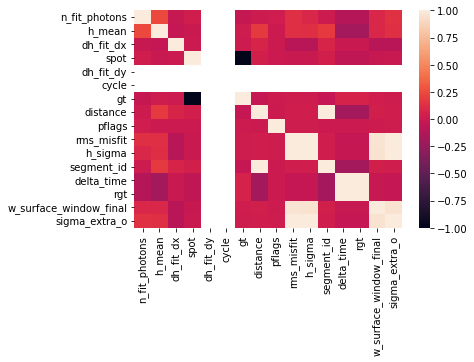

In [130]:
sns.heatmap(corr);